## Imports


In [1]:
# Adding needed libraries and reading data
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

train = pd.read_csv('../artifact/train.csv')
test = pd.read_csv('../artifact/test.csv')

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Missing Values

In [3]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4.0
LotFrontage,259,227.0
Alley,1369,1352.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,872,894.0
MasVnrArea,8,15.0
BsmtQual,37,44.0
BsmtCond,37,45.0


In [4]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [5]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

## Fill NAN and Converting features

In [6]:
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [7]:
features.shape

(2919, 54)

## Log transforming

C:\Users\m477a\AppData\Local\Temp\ipykernel_19644\3445750104.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_labels)


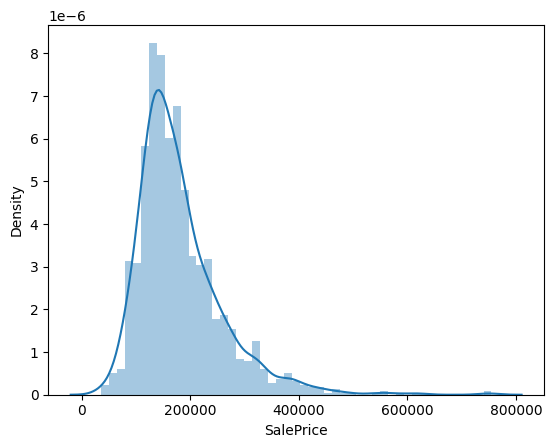

In [8]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

In [9]:
## Log transformation of labels
train_labels = np.log(train_labels)

C:\Users\m477a\AppData\Local\Temp\ipykernel_19644\2645756389.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_labels)


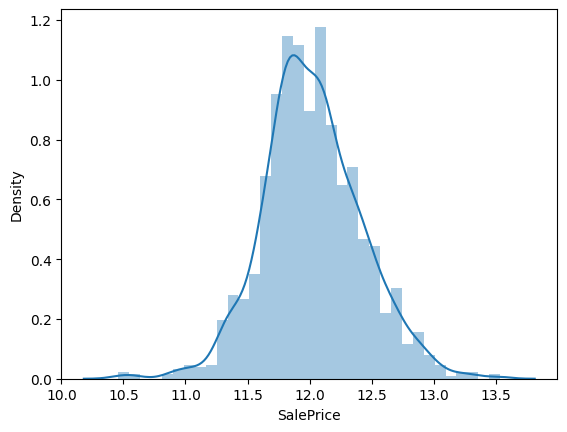

In [10]:
## Now it looks much better
ax = sns.distplot(train_labels)

## Standardizing numeric data

In [11]:
## Standardizing numeric features
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

In [12]:
numeric_features

LotFrontage  LotArea  GrLivArea  TotalSF
train 0            65.0     8450       1710   2566.0
      1            80.0     9600       1262   2524.0
      2            68.0    11250       1786   2706.0
      3            60.0     9550       1717   2473.0
      4            84.0    14260       2198   3343.0
...                 ...      ...        ...      ...
test  1454         21.0     1936       1092   1638.0
      1455         21.0     1894       1092   1638.0
      1456        160.0    20000       1224   2448.0
      1457         62.0    10441        970   1882.0
      1458         74.0     9627       2000   2996.0

[2919 rows x 4 columns]

In [13]:
numeric_features_standardized

LotFrontage   LotArea  GrLivArea   TotalSF
train 0       -0.202033 -0.217841   0.413476  0.022999
      1        0.501785 -0.072032  -0.471810 -0.029167
      2       -0.061269  0.137173   0.563659  0.196886
      3       -0.436639 -0.078371   0.427309 -0.092511
      4        0.689469  0.518814   1.377806  0.988072
...                 ...       ...        ...       ...
test  1454    -2.266564 -1.043758  -0.807744 -1.129623
      1455    -2.266564 -1.049083  -0.807744 -1.129623
      1456     4.255477  1.246594  -0.546901 -0.123562
      1457    -0.342796  0.034599  -1.048827 -0.826563
      1458     0.220258 -0.068608   0.986541  0.557081

[2919 rows x 4 columns]

### Converting categorical data to dummies

In [14]:
# Getting Dummies from Condition1 and Condition2
conditions = list(set(features['Condition1'].dropna().unique()).union(features['Condition2'].dropna().unique()))
dummies = pd.DataFrame(data=np.zeros((len(features), len(conditions))), index=features.index, columns=conditions)

for i, (cond1, cond2) in enumerate(zip(features['Condition1'], features['Condition2'])):
    if pd.notna(cond1):
        dummies.loc[i, cond1] = 1
    if pd.notna(cond2):
        dummies.loc[i, cond2] = 1

features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Getting Dummies from Exterior1st and Exterior2nd
exteriors = list(set(features['Exterior1st'].dropna().unique()).union(features['Exterior2nd'].dropna().unique()))
dummies = pd.DataFrame(data=np.zeros((len(features), len(exteriors))), index=features.index, columns=exteriors)

for i, (ext1, ext2) in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    if pd.notna(ext1):
        dummies.loc[i, ext1] = 1
    if pd.notna(ext2):
        dummies.loc[i, ext2] = 1

features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

# Getting Dummies from all other categorical variables
categorical_cols = features.select_dtypes(include='object').columns
for col in categorical_cols:
    dummies = pd.get_dummies(features[col], prefix=col, drop_first=False)  # Use drop_first=True if desired
    features = pd.concat([features, dummies], axis=1)
    features.drop(col, axis=1, inplace=True)


In [15]:
type(features)

pandas.core.frame.DataFrame

In [16]:
features.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=262)

## from here
_____________________________________

In [17]:
features.head()

Id  LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  \
train 0  1.0         65.0   8450.0          7.0     2003.0        2003.0   
      1  2.0         80.0   9600.0          6.0     1976.0        1976.0   
      2  3.0         68.0  11250.0          7.0     2001.0        2002.0   
      3  4.0         60.0   9550.0          7.0     1915.0        1970.0   
      4  5.0         84.0  14260.0          8.0     2000.0        2000.0   

         GrLivArea  FullBath  HalfBath  BedroomAbvGr  ...  SaleType_ConLw  \
train 0     1710.0       2.0       1.0           3.0  ...           False   
      1     1262.0       2.0       0.0           3.0  ...           False   
      2     1786.0       2.0       1.0           3.0  ...           False   
      3     1717.0       1.0       0.0           3.0  ...           False   
      4     2198.0       2.0       1.0           4.0  ...           False   

         SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
train 0         False         False         True                  False   
      1         False         False         True                  False   
      2         False         False         True                  False   
      3         False         False         True                   True   
      4         False         False         True                  False   

         SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
train 0                  False                 False                 False   
      1                  False                 False                 False   
      2                  False                 False                 False   
      3                  False                 False                 False   
      4                  False                 False                 False   

         SaleCondition_Normal  SaleCondition_Partial  
train 0                  True                  False  
      1                  True                  False  
      2                  True                  False  
      3                 False                  False  
      4                  True                  False  

[5 rows x 262 columns]

In [18]:
# features.drop(['Id'], axis=1, inplace=True)

In [18]:
features.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=262)

In [19]:
type(features)

pandas.core.frame.DataFrame

In [20]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5838 entries, ('train', 0) to (2918, '')
Columns: 262 entries, Id to SaleCondition_Partial
dtypes: bool(220), float64(42)
memory usage: 3.4+ MB


In [21]:
features = features.iloc[:, : 11] # 14
# features = features[["LotArea","MasVnrArea","BsmtFinSF1",
#                     "BsmtFinSF2","BsmtUnfSF","1stFlrSF",
#                     "2ndFlrSF","GrLivArea","GarageArea",
#                     "WoodDeckSF","OpenPorchSF","PoolArea"]]

In [22]:
features.head()

Id  LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  \
train 0  1.0         65.0   8450.0          7.0     2003.0        2003.0   
      1  2.0         80.0   9600.0          6.0     1976.0        1976.0   
      2  3.0         68.0  11250.0          7.0     2001.0        2002.0   
      3  4.0         60.0   9550.0          7.0     1915.0        1970.0   
      4  5.0         84.0  14260.0          8.0     2000.0        2000.0   

         GrLivArea  FullBath  HalfBath  BedroomAbvGr  TotRmsAbvGrd  
train 0     1710.0       2.0       1.0           3.0           8.0  
      1     1262.0       2.0       0.0           3.0           6.0  
      2     1786.0       2.0       1.0           3.0           6.0  
      3     1717.0       1.0       0.0           3.0           7.0  
      4     2198.0       2.0       1.0           4.0           9.0

In [23]:
features.describe()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,69.305795,10168.114080,6.089072,1971.312778,1984.264474,1500.759849,1.568003,0.380267,2.860226,6.451524
std,842.787043,21.312345,7886.996359,1.409947,30.291442,20.894344,506.051045,0.552969,0.502872,0.822693,1.569379
min,1.000000,21.000000,1300.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,0.000000,2.000000
25%,730.500000,60.000000,7478.000000,5.000000,1953.500000,1965.000000,1126.000000,1.000000,0.000000,2.000000,5.000000
50%,1460.000000,69.305795,9453.000000,6.000000,1973.000000,1993.000000,1444.000000,2.000000,0.000000,3.000000,6.000000
75%,2189.500000,78.000000,11570.000000,7.000000,2001.000000,2004.000000,1743.500000,2.000000,1.000000,3.000000,7.000000
max,2919.000000,313.000000,215245.000000,10.000000,2010.000000,2010.000000,5642.000000,4.000000,2.000000,8.000000,15.000000


In [24]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5838 entries, ('train', 0) to (2918, '')
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2919 non-null   float64
 1   LotFrontage   2919 non-null   float64
 2   LotArea       2919 non-null   float64
 3   OverallQual   2919 non-null   float64
 4   YearBuilt     2919 non-null   float64
 5   YearRemodAdd  2919 non-null   float64
 6   GrLivArea     2919 non-null   float64
 7   FullBath      2919 non-null   float64
 8   HalfBath      2919 non-null   float64
 9   BedroomAbvGr  2919 non-null   float64
 10  TotRmsAbvGrd  2919 non-null   float64
dtypes: float64(11)
memory usage: 784.6+ KB


In [25]:
features.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd'],
      dtype='object')

### Test

### Obtaining standardized dataset

In [26]:
### Copying features
# features_standardized = features.copy()    

### Replacing numeric features by standardized values
# features_standardized.update(numeric_features_standardized)

### Splitting train and test 

In [27]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

# ### Splitting standardized features
# train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
# test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [28]:
features.head(1)

,,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd
train,0,1.0,65.0,8450.0,7.0,2003.0,2003.0,1710.0,2.0,1.0,3.0,8.0


In [29]:
features.values[0]

array([1.000e+00, 6.500e+01, 8.450e+03, 7.000e+00, 2.003e+03, 2.003e+03,
       1.710e+03, 2.000e+00, 1.000e+00, 3.000e+00, 8.000e+00])

In [30]:
train_features[0]

array([6.500e+01, 8.450e+03, 7.000e+00, 2.003e+03, 2.003e+03, 1.710e+03,
       2.000e+00, 1.000e+00, 3.000e+00, 8.000e+00])

In [31]:
type(train_features)

numpy.ndarray

In [32]:
print(train_features.shape)
print(test_features.shape)
# print(train_features_st.shape)
# print(test_features_st.shape)

(1460, 10)
(1459, 10)


### Splitting train and validation 

In [33]:
### Shuffling train sets
# train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state=0)

In [34]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=0)
# x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=0)

In [35]:
type(x_train)

numpy.ndarray

In [36]:
print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)

x_train:  (1314, 10)
y_train:  (1314,)
x_test:  (146, 10)
y_test:  (146,)


### Gradient Boosting

In [37]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)

In [38]:
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=3000)
R2: 0.9380037464621716
RMSE: 0.09425157654829847
Test
R2: 0.8465459628953276
RMSE: 0.1343135524048453


In [39]:
pred = GBest.predict(x_test)

In [40]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

r2 = r2_score(y_test, pred)
mse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
    
print("R-Square: ",r2) 
print("RMSE: ",mse) 
print("MAE: ",mae)

R-Square:  0.868255096378551
RMSE:  0.1343135524048453
MAE:  0.09280024348931505


In [41]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42).fit(x_train, y_train)

predictions3 = xgboost.predict(x_test)

r2 = r2_score(y_test, predictions3)
mse = np.sqrt(mean_squared_error(y_test, predictions3))
mae = mean_absolute_error(y_test, predictions3)
    
print("R-Square: ",r2) 
print("RMSE: ",mse) 
print("MAE: ",mae)

c:\Users\m477a\Anaconda3\envs\mlops2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


R-Square:  0.8385447300299135
RMSE:  0.1486890669733642
MAE:  0.10076702206269089


In [42]:
# Average R2 score and standart deviation of 5-fold cross-validation
# scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
scores = cross_val_score(GBest, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.03)


In [43]:
gbpred = GBest.predict(x_test)

In [44]:
x_train[0]

array([7.300e+01, 8.925e+03, 8.000e+00, 2.007e+03, 2.007e+03, 1.466e+03,
       2.000e+00, 0.000e+00, 3.000e+00, 7.000e+00])

In [45]:
x_test[0]

array([6.93057953e+01, 3.26680000e+04, 6.00000000e+00, 1.95700000e+03,
       1.97500000e+03, 2.51500000e+03, 3.00000000e+00, 0.00000000e+00,
       4.00000000e+00, 9.00000000e+00])

In [41]:
# np.expm1(x_test[0])

In [46]:
gbpred = np.expm1(gbpred)
gbpred

array([246433.62215552, 138552.97670931, 124600.41453996, 194993.78980476,
        95852.95882654,  98642.26398349, 212438.86189048, 125747.16716287,
       361062.07826318, 166978.90156949, 200378.07111276, 158556.45158841,
       227253.21144248, 114550.11467981, 115578.86637627, 138208.53845357,
       211555.47321369, 133120.85168975, 148496.62862439, 149639.76932637,
       115924.24929927, 143286.66803001, 113667.93740676, 170886.63207989,
       170229.98330122, 176752.87756884, 171587.58805251,  77635.71451149,
       329220.05491681, 117319.29162486, 132291.09185312, 199272.11479134,
       136132.22722881, 284641.79097709, 297682.97798257, 199784.96442326,
       297300.12124551, 124750.71680652, 231116.49992963, 349686.96231422,
       196277.02561644, 125321.31550945, 192081.79770787, 273531.19038015,
       319705.35200715, 137498.22569479, 116346.13680368, 129457.59215759,
       165983.00259141, 110011.85032941, 440776.58155147, 136543.86208942,
       166037.9669583 ,  

In [47]:
y_test = np.expm1(y_test)
y_test

529     200623.0
491     132999.0
459     109999.0
279     191999.0
655      87999.0
          ...   
1452    144999.0
113     216999.0
1282    150499.0
1163    108958.0
310     165599.0
Name: SalePrice, Length: 146, dtype: float64

In [44]:
# print(f'pred: {gbpred[0]}, true: {y_test[0]}')

### Preprocessing

In [63]:
test_1 = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values[0]
test_1 = test_1[:10]
reshaped = test_1.reshape(1, 10)
pred = GBest.predict(reshaped)
pred = np.expm1(pred)

In [64]:
pred[0]

np.float64(195116.87737231038)

In [65]:
integer_value = int(pred[0])  # Access the first (and only) element and convert
print(integer_value) 

195116
